# Housing Prices

In [1]:
import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action="ignore")

from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load dataset used to create previously developed housing prices model.

In [2]:
df_model = pd.read_csv('housing_price_model.csv')

## Modeling

In [3]:
features = df_model.columns.tolist()
features.remove('saleprice_sd_bc_tk')
X = df_model.loc[:, features]
y = df_model['saleprice_sd_bc_tk']

X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

## Model Evaluation

In [4]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     saleprice_sd_bc_tk   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     135.3
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:01:52   Log-Likelihood:                 1871.0
No. Observations:                1460   AIC:                            -3578.
Df Residuals:                    1378   BIC:                            -3145.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [5]:
df_results = pd.concat([results.params, results.pvalues], axis=1)
df_results.reset_index(inplace=True)
df_results.columns = ['feature', 'coeff', 'pvalue']

In [6]:
df_results.describe().T

,count,mean,std,min,25%,50%,75%,max
coeff,82.0,-0.026976,0.153705,-1.299999e+00,-0.036628,-0.010866,0.021870,0.269351
pvalue,82.0,0.222305,0.290354,1.538251e-100,0.000600,0.052324,0.422097,0.990901


### Significant features
Filter out features that have a pvalue > 0.05.

In [7]:
df_filtered = df_results[df_results['pvalue'] < 0.05].copy()

In [8]:
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
coeff,41.0,-0.050599,0.214569,-1.299999e+00,-5.080555e-02,-0.028656,0.029487,0.269351
pvalue,41.0,0.004394,0.008501,1.538251e-100,2.465959e-07,0.000590,0.003676,0.041712


### Rerun model
Rerun the model with only the significant features.

In [9]:
filtered_features = df_filtered['feature'].tolist()
filtered_features.remove('const')

In [10]:
print(f'Removed {len(features) - len(filtered_features)} features. The number of features is now {len(filtered_features)}.')

Removed 41 features. The number of features is now 40.


In [11]:
df_model_2 = df_model.loc[:, filtered_features].copy()
df_model_2['saleprice_sd_bc_tk'] = df_model['saleprice_sd_bc_tk']

In [12]:
X = df_model_2.loc[:, filtered_features]
y = df_model_2['saleprice_sd_bc_tk']

X = sm.add_constant(X)

results_2 = sm.OLS(y, X).fit()

In [13]:
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:     saleprice_sd_bc_tk   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     270.1
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:01:52   Log-Likelihood:                 1842.9
No. Observations:                1460   AIC:                            -3604.
Df Residuals:                    1419   BIC:                            -3387.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [14]:
df_results_2 = pd.concat([results_2.params, results_2.pvalues], axis=1)
df_results_2.reset_index(inplace=True)
df_results_2.columns = ['feature', 'coeff', 'pvalue']

# Remove the bias term
df_results_2 = df_results_2[df_results_2['feature'] != 'const']

In [15]:
df_results_2.describe().T

,count,mean,std,min,25%,50%,75%,max
coeff,40.0,-0.015520,0.076753,-1.791601e-01,-5.041108e-02,-0.019916,0.031384,0.267014
pvalue,40.0,0.003978,0.013364,1.777977e-116,5.351055e-09,0.000078,0.000953,0.080506


In [16]:
# Create a column with absoluate values for the coefficients
df_results_2['abs_coeff'] = np.abs(df_results_2['coeff'])

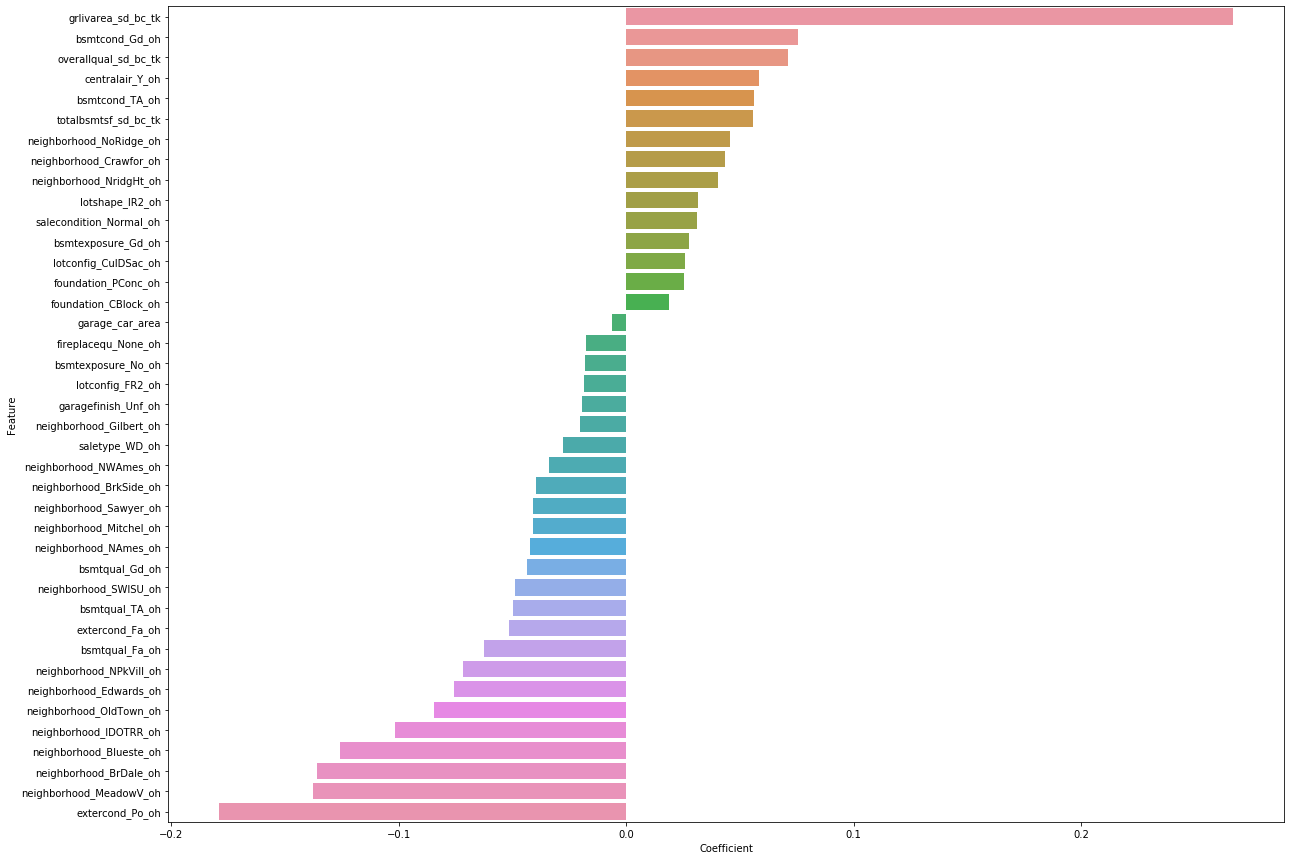

In [17]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='coeff', y='feature', data=df_results_2.sort_values(by='coeff', ascending=False))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

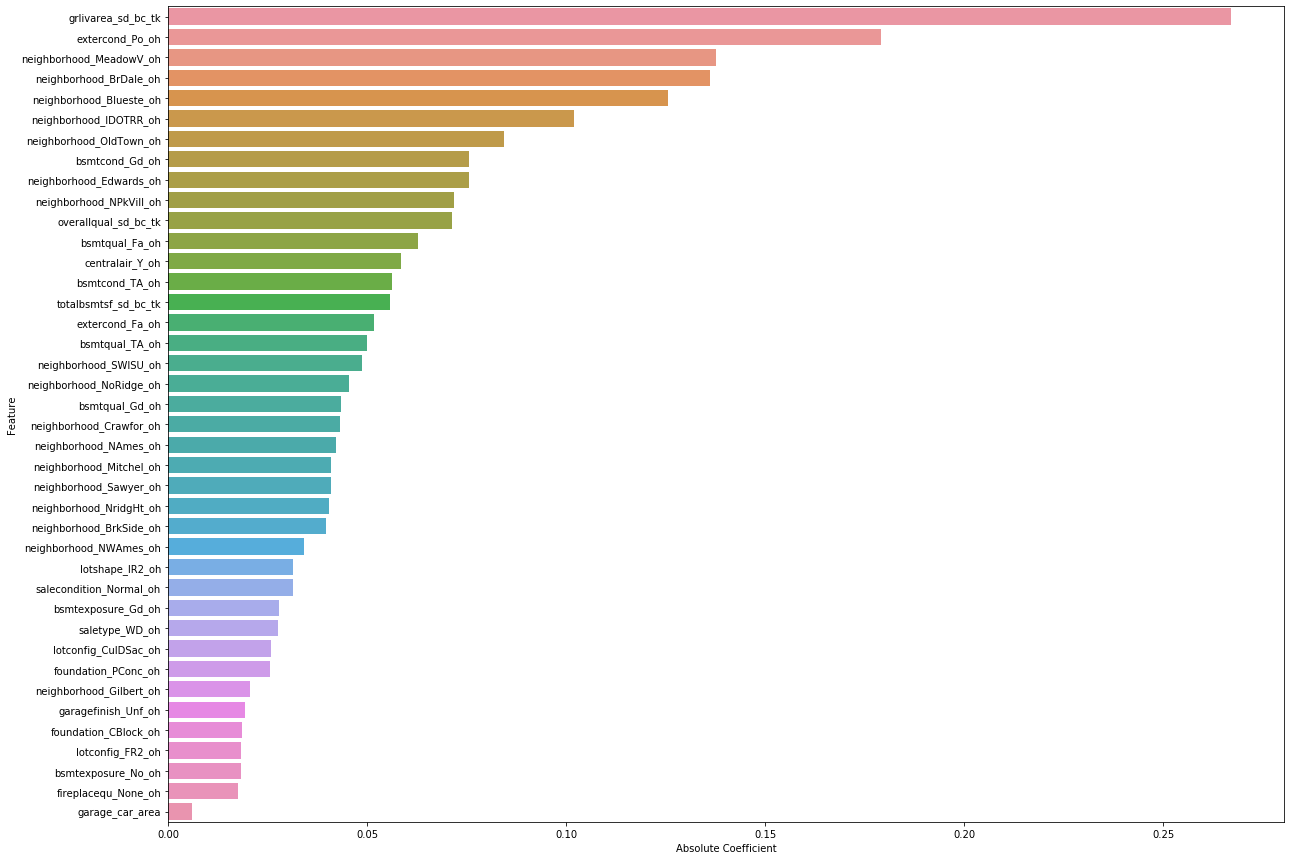

In [18]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x='abs_coeff', y='feature', data=df_results_2.sort_values(by='abs_coeff', ascending=False))
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

**Observations:**

The most important feature is `'grlivarea_sd_bc_tk'`, above ground living area. The next most important feature is `'extercond_Po_oh'`, the external condition of the house. After that, the neighborhood features are important. I can conclude that housing price is most strongly related to the size of the house and its condition. In addition, its location has a strong effect on housing price as well.

### Save Dataset
Save dataset used for second model to a csv file.

In [21]:
df_model_2.to_csv('./housing_prices_pvalue_cut.csv', index=False)